In [1]:
from transformers import CamembertTokenizer, CamembertModel, AutoTokenizer, AutoModel, utils
import torch
from scipy.spatial.distance import cosine
from bertviz import model_view, head_view
import itertools
from IPython import display
#utils.logging.set_verbosity_error()  # Suppress standard warnings

c:\Users\Etudiant\M1_TAL\m1-supervised-project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


First method

In [6]:
# Initialisation du tokenizer et du modèle CamemBERT
model_version = 'camembert-base'
model = CamembertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = CamembertTokenizer.from_pretrained(model_version)

"""
# Phrases à analyser
#phrase1 = "Il porte son attention sur le problème."
#phrase2 = "Il porte un pot de miel à sa grand-mère."

phrase1 = "Elle éprouve une immense haine pour lui."
phrase2 = "Elle éprouve de grandes difficultés à finir son projet à temps."

#phrase1 = "Il prend un objet dans sa main."
#phrase2 = "Elle prend une décision importante."
"""

#phrase1 = "On court dans le désert."
#phrase2 = "On court le risque de perdre le match."
phrase2 = "Il prend une décision importante."
phrase1 = "Il prend un objet dans sa main."
# Encodage des phrases pour le modèle
inputs = tokenizer(phrase1, phrase2, return_tensors='pt', padding=True)
# Extraction des inputs nécessaires
input_ids = inputs['input_ids']
attention = model(input_ids, attention_mask=inputs['attention_mask']).attentions

# Conversion des IDs de tokens en tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# Utilisation de BertViz pour visualiser l'attention

# Tokenisation et création des masques d'attention
tokens_tensor1, attention_mask1 = tokenizer.encode_plus(phrase1, return_tensors='pt').values()
tokens_tensor2, attention_mask2 = tokenizer.encode_plus(phrase2, return_tensors='pt').values()

# Extraction des embeddings
with torch.no_grad():
    outputs1 = model(tokens_tensor1, attention_mask=attention_mask1)
    outputs2 = model(tokens_tensor2, attention_mask=attention_mask2)

# Identification de l'indice du token qu'on souhaite (nécessite parfois ajustement)
index_of_word = 2  # Exemple d'indice, vérifiez le bon index avec tokenizer.tokenize(phrase1)
embedding1 = outputs1.last_hidden_state[0, index_of_word, :]
embedding2 = outputs2.last_hidden_state[0, index_of_word, :]

# Calcul de la similarité cosinus
similarity = 1 - cosine(embedding1, embedding2)

print(f"La similarité cosinus entre les deux utilisations de 'prend' est de {similarity:.2f}")


c:\Users\Etudiant\M1_TAL\m1-supervised-project\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


La similarité cosinus entre les deux utilisations de 'prend' est de 0.84


Second method (better ?)

In [2]:
# Initialisation du tokenizer et du modèle CamemBERT
model_version = 'camembert-base'
model = CamembertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = CamembertTokenizer.from_pretrained(model_version)

# Phrases à analyser

#phrase1 = "On court dans le désert."
#phrase2 = "On court le risque de perdre le match."

phrase2 = "Il prend une décision importante."
phrase1 = "Il prend un objet dans sa main."

# Tokenisation des phrases en considérant la casse et les subwords
tokens1 = [token.lower() for token in tokenizer.tokenize(phrase1)]
tokens2 = [token.lower() for token in tokenizer.tokenize(phrase2)]

# Mot à chercher, en minuscule pour éviter les problèmes de casse
word = 'prend'.lower()

# Trouver les indices du mot ou de son subword principal dans chaque phrase
index_word1 = next((i for i, token in enumerate(tokens1) if word in token), None)
index_word2 = next((i for i, token in enumerate(tokens2) if word in token), None)

# Encodage et extraction des embeddings si le mot est trouvé dans les deux phrases
if index_word1 is not None and index_word2 is not None:
    inputs1 = tokenizer.encode_plus(phrase1, return_tensors='pt')
    inputs2 = tokenizer.encode_plus(phrase2, return_tensors='pt')

    with torch.no_grad():
        outputs1 = model(**inputs1)
        outputs2 = model(**inputs2)

    embedding1 = outputs1.last_hidden_state[0, index_word1, :]
    embedding2 = outputs2.last_hidden_state[0, index_word2, :]

    # Calcul de la similarité cosinus
    similarity = 1 - cosine(embedding1, embedding2)

    print(f"La similarité cosinus entre les deux utilisations de '{word}' est de {similarity:.2f}")
else:
    print("Impossible de calculer la similarité car le mot n'est pas trouvé dans une ou les deux phrases.")


c:\Users\Etudiant\M1_TAL\m1-supervised-project\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


La similarité cosinus entre les deux utilisations de 'prend' est de 0.97


In [3]:
# Initialisation du tokenizer et du modèle CamemBERT (supposée déjà faite)

model_version = 'camembert-base'
tokenizer = CamembertTokenizer.from_pretrained(model_version)
model = CamembertModel.from_pretrained(model_version, output_attentions=True)

# Phrases avec le verbe 'courir'
phrases = [
    "Il court un péril en allant là-bas.",
    "Le buzz court sur les réseaux sociaux.",
    "Le bruit court dans les couloirs.",
    "Elle court sur la route.",
    "Le danger court dans les zones inexplorées.",
    "Le nuage court dans le ciel orageux.",
    "Le risque court dans chaque décision d'investissement."
]

# Verbe à analyser
word = 'court'

# Comparer chaque paire de phrases
for phrase1, phrase2 in itertools.combinations(phrases, 2):
    tokens1 = [token.lower() for token in tokenizer.tokenize(phrase1)]
    tokens2 = [token.lower() for token in tokenizer.tokenize(phrase2)]

    index_word1 = next((i for i, token in enumerate(tokens1) if word in token), None)
    index_word2 = next((i for i, token in enumerate(tokens2) if word in token), None)

    if index_word1 is not None and index_word2 is not None:
        inputs1 = tokenizer.encode_plus(phrase1, return_tensors='pt')
        inputs2 = tokenizer.encode_plus(phrase2, return_tensors='pt')

        with torch.no_grad():
            outputs1 = model(**inputs1)
            outputs2 = model(**inputs2)

        embedding1 = outputs1.last_hidden_state[0, index_word1, :]
        embedding2 = outputs2.last_hidden_state[0, index_word2, :]

        similarity = 1 - cosine(embedding1.numpy(), embedding2.numpy())
        print(f"Similarity for '{word}' between '{phrase1}' and '{phrase2}': {similarity:.2f}")
    else:
        print(f"Impossible de calculer la similarité entre '{phrase1}' et '{phrase2}' car le mot '{word}' n'est pas trouvé dans une des deux phrases.")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Similarity for 'court' between 'Il court un péril en allant là-bas.' and 'Le buzz court sur les réseaux sociaux.': 0.64
Similarity for 'court' between 'Il court un péril en allant là-bas.' and 'Le bruit court dans les couloirs.': 0.64
Similarity for 'court' between 'Il court un péril en allant là-bas.' and 'Elle court sur la route.': 0.92
Similarity for 'court' between 'Il court un péril en allant là-bas.' and 'Le danger court dans les zones inexplorées.': 0.72
Similarity for 'court' between 'Il court un péril en allant là-bas.' and 'Le nuage court dans le ciel orageux.': 0.59
Similarity for 'court' between 'Il court un péril en allant là-bas.' and 'Le risque court dans chaque décision d'investissement.': 0.65
Similarity for 'court' between 'Le buzz court sur les réseaux sociaux.' and 'Le bruit court dans les couloirs.': 0.69
Similarity for 'court' between 'Le buzz court sur les réseaux sociaux.' and 'Elle court sur la route.': 0.63
Similarity for 'court' between 'Le buzz court sur les

In [4]:
model.eval()

CamembertModel(
  (embeddings): CamembertEmbeddings(
    (word_embeddings): Embedding(32005, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): CamembertEncoder(
    (layer): ModuleList(
      (0-11): 12 x CamembertLayer(
        (attention): CamembertAttention(
          (self): CamembertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): CamembertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
     

In [3]:

# Initialize the model and tokenizer
model_version = 'camembert-base'
model = CamembertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = CamembertTokenizer.from_pretrained(model_version)

# Define the sentences
#sentence_a = "Il porte son attention sur le problème."
#sentence_b = "Il porte un pot de miel à sa grand-mère."
#sentence_a = "Elle éprouve une immense haine pour lui."
#sentence_b = "Elle éprouve de grandes difficultés à finir son projet à temps."
sentence_a = "Il prend une décision importante."
sentence_b = "Il prend un objet dans sa main."
# Tokenize the sentences
inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt', padding=True, truncation=True)

# Extract inputs
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

# Get model outputs, remove token_type_ids since Camembert does not use them
outputs = model(input_ids, attention_mask=attention_mask)
attention = outputs.attentions

# Convert input IDs to tokens for display or further analysis
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

print("Tokens:", tokens)


c:\Users\Etudiant\M1_TAL\m1-supervised-project\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Tokens: ['<s>', '▁Il', '▁prend', '▁une', '▁décision', '▁importante', '.', '</s>', '</s>', '▁Il', '▁prend', '▁un', '▁objet', '▁dans', '▁sa', '▁main', '.', '</s>']


BERTVIZ for CamemBERT

In [4]:
model_version = 'camembert-base'
model = CamembertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = CamembertTokenizer.from_pretrained(model_version)
#sentence_a = "Il porte son attention sur le problème."
#sentence_b = "Il porte un pot de miel à sa grand-mère."
#sentence_a = "Elle éprouve une immense haine pour lui."
#sentence_b = "Elle éprouve de grandes difficultés à finir son projet à temps "
sentence_a = "Il prend une décision importante."
sentence_b = "Il prend un objet dans sa main."
inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt')
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']
# Get model outputs, focusing on attentions
outputs = model(input_ids, attention_mask=attention_mask)
attention = outputs.attentions

# Convert input IDs back to tokens for visualization
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
head_view(attention, tokens)
model_view(attention, tokens, include_layers=[1,2,3])



"""
token_type_ids = inputs['token_type_ids'] # token type id is 0 for Sentence A and 1 for Sentence B
attention = model(input_ids, token_type_ids=token_type_ids)[-1]
sentence_b_start = token_type_ids[0].tolist().index(1) # Sentence B starts at first index of token type id 1
token_ids = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(token_ids)
head_view(attention, tokens, sentence_b_start)
"""

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

"\ntoken_type_ids = inputs['token_type_ids'] # token type id is 0 for Sentence A and 1 for Sentence B\nattention = model(input_ids, token_type_ids=token_type_ids)[-1]\nsentence_b_start = token_type_ids[0].tolist().index(1) # Sentence B starts at first index of token type id 1\ntoken_ids = input_ids[0].tolist() # Batch index 0\ntokens = tokenizer.convert_ids_to_tokens(token_ids)\nhead_view(attention, tokens, sentence_b_start)\n"

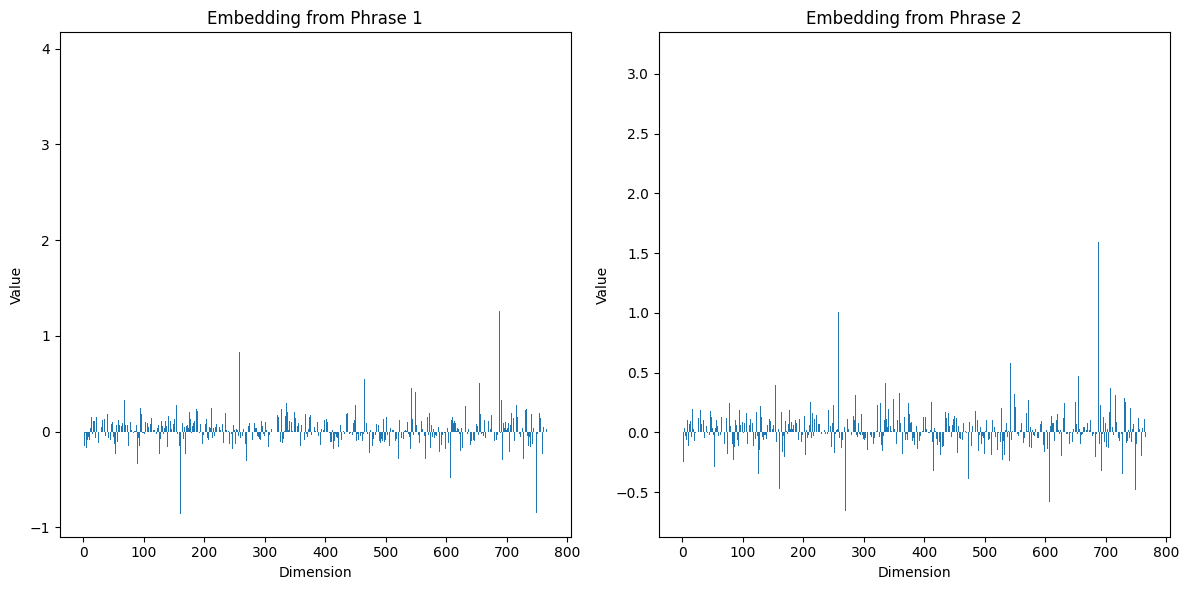

In [7]:
import matplotlib.pyplot as plt
import numpy as np
# Plotting the embeddings
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Embedding from Phrase 1')
plt.bar(np.arange(len(embedding1)), embedding1.numpy())
plt.xlabel('Dimension')
plt.ylabel('Value')

plt.subplot(1, 2, 2)
plt.title('Embedding from Phrase 2')
plt.bar(np.arange(len(embedding2)), embedding2.numpy())
plt.xlabel('Dimension')
plt.ylabel('Value')

plt.tight_layout()
plt.show()